In [94]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import random
import warnings
warnings.filterwarnings("ignore")

The goal of this work is to create a model based on a convolution neural network for binary image classification (images with tablets and capsules)

## Data exploration

In [2]:
data_directory = os.getcwd() + '/data' # dirpath contains folders with images
for dirpath, dirnames, filenames in os.walk(data_directory):
    print(f"{dirpath} has {len(filenames)} images and {len(dirnames)} folders")

d:\Python\Проекты\Классификация таблетки, капсулы/data has 0 images and 2 folders
d:\Python\Проекты\Классификация таблетки, капсулы/data\capsules has 315 images and 0 folders
d:\Python\Проекты\Классификация таблетки, капсулы/data\tablets has 259 images and 0 folders


In [3]:
data_directory

'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data'

In [4]:
def image_plot(image_directory):
    '''
    Plots random images from directory for each class
    
    Args:
        image_directory (str): string dirpath contains folders with images
    '''
    
    class_names = ['tablets', 'capsules']
    
    fig = plt.figure(figsize=(10,7))

    for i, img in enumerate(class_names):
        ax = plt.subplot(1, 2, i+1)
        
        class_path = data_directory + '/' + img
        random_image_path = class_path + '/' + random.sample(os.listdir(class_path), 1)[0]
        image = mpimg.imread(random_image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(img.title())

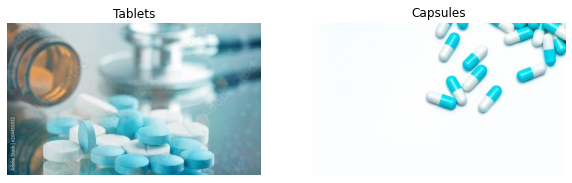

In [5]:
# Plotting random images from two classes
image_plot(data_directory)

## Building model with your own architecture without data augmentation

In [6]:
SHAPE = (224, 224) # shape of target size
BATCH_SIZE = 32 # batch size

datagen_without_augm = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_ds = datagen_without_augm.flow_from_directory(data_directory,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=SHAPE,
                                                    class_mode="binary",
                                                    subset='training',
                                                    seed=42)

val_ds = datagen_without_augm.flow_from_directory(data_directory,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=SHAPE,
                                                  class_mode="binary",
                                                  subset='validation',
                                                  shuffle=False,
                                                  seed=42)

Found 460 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [7]:
def plot_ds_images(dataset, rescaled=True):
    
    '''
    Plots three random images from dataset
    
    Args:
        dataset: tf.data.Datasets contains rescaled images
        rescaled (bool): whether pixel values are scaled to range(0, 1), default True
    '''
    
    fig = plt.figure(figsize=(15, 5))
    
    name_of_classes = list(train_ds.class_indices.keys())
    
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        
        
        random_batch = random.randint(0, len(dataset)-1)
        random_image = random.randint(0, len(dataset[random_batch][0])-1)
        image = dataset[random_batch][0][random_image]
        
        if not rescaled:
            image = image / 255.0 # rescaling images
        
        title = name_of_classes[int(dataset[random_batch][1][random_image])]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(str(title))

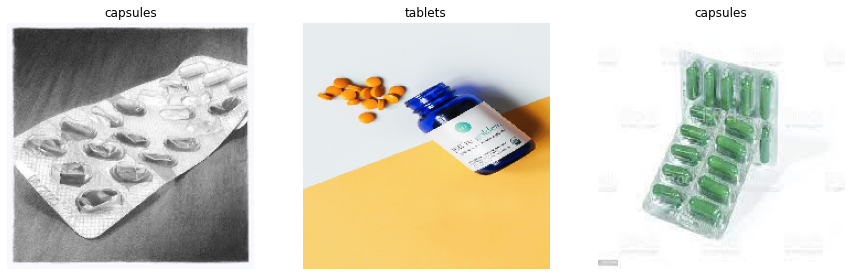

In [8]:
# Plot three random images from dataset
plot_ds_images(train_ds)

In [9]:
my_model_without_augm = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3,
                           activation='relu',
                           input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [10]:
my_model_without_augm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [11]:
checkpoints_path = 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\checkpoints\\' # directory for checkpoints
tensorboard_path = 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\tensorboards\\' # directory for tensorboard

In [12]:
my_model_without_augm.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(),
                              metrics='accuracy')

history_my_model_without_augm = my_model_without_augm.fit(train_ds, 
                                                          epochs=20, 
                                                          steps_per_epoch=len(train_ds), 
                                                          validation_data=val_ds, 
                                                          validation_steps=len(val_ds),
                                                          callbacks=[
                                                              tf.keras.callbacks.ModelCheckpoint(checkpoints_path, 
                                                                                                 save_weights_only=True,
                                                                                                 save_best_only=True,
                                                                                                 verbose=0),
                                                              tf.keras.callbacks.TensorBoard(tensorboard_path)])

Epoch 1/20
15/15 [==============================] - 18s 734ms/step - loss: 1.2622 - accuracy: 0.5261 - val_loss: 0.6997 - val_accuracy: 0.4474
Epoch 2/20
15/15 [==============================] - 8s 540ms/step - loss: 0.6896 - accuracy: 0.5587 - val_loss: 0.6883 - val_accuracy: 0.5526
Epoch 3/20
15/15 [==============================] - 9s 543ms/step - loss: 0.6750 - accuracy: 0.5804 - val_loss: 0.6838 - val_accuracy: 0.5526
Epoch 4/20
15/15 [==============================] - 8s 523ms/step - loss: 0.6596 - accuracy: 0.6283 - val_loss: 0.6777 - val_accuracy: 0.5439
Epoch 5/20
15/15 [==============================] - 10s 654ms/step - loss: 0.6285 - accuracy: 0.6565 - val_loss: 0.6626 - val_accuracy: 0.5702
Epoch 6/20
15/15 [==============================] - 9s 583ms/step - loss: 0.5649 - accuracy: 0.6761 - val_loss: 0.6268 - val_accuracy: 0.6842
Epoch 7/20
15/15 [==============================] - 9s 586ms/step - loss: 0.5257 - accuracy: 0.7435 - val_loss: 0.6283 - val_accuracy: 0.6667
Epoc

In [13]:
my_model_without_augm_score = my_model_without_augm.evaluate(val_ds)

4/4 [==============================] - 1s 249ms/step - loss: 1.4929 - accuracy: 0.6754


In [14]:
def plot_history(history):
    
    '''
    Plots history of model
    
    Args:
        history: tf.keras.callbacks.History that records events into a History object
    '''
    
    df = pd.DataFrame(history.history)
    df[['loss', 'val_loss']].plot(title='Loss plot', xlabel='Epochs', ylabel='Loss')
    
    df[['accuracy', 'val_accuracy']].plot(title='Accuracy plot', xlabel='Epochs', ylabel='Accuracy')

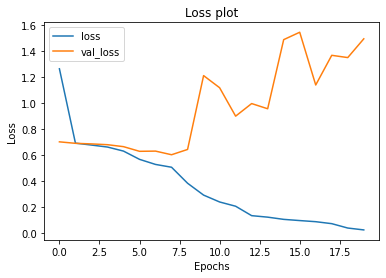

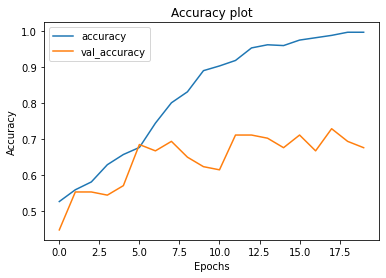

In [15]:
plot_history(history_my_model_without_augm)

Model has overfitted, dadta augmentation can help prevent overfitting

## Building model with your own architecture with data augmentation

In [16]:
datagen_with_augm = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                       validation_split=0.2,
                                                                       rotation_range=0.3,
                                                                       width_shift_range=0.2,
                                                                       height_shift_range=0.2,
                                                                       zoom_range=0.2,
                                                                       horizontal_flip=True,
                                                                       vertical_flip=True)


train_ds = datagen_with_augm.flow_from_directory(data_directory,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=SHAPE,
                                                    class_mode="binary",
                                                    subset='training',
                                                    seed=42)

val_ds = datagen_with_augm.flow_from_directory(data_directory,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=SHAPE,
                                                  class_mode="binary",
                                                  subset='validation',
                                                  shuffle=False,
                                                  seed=42)

Found 460 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


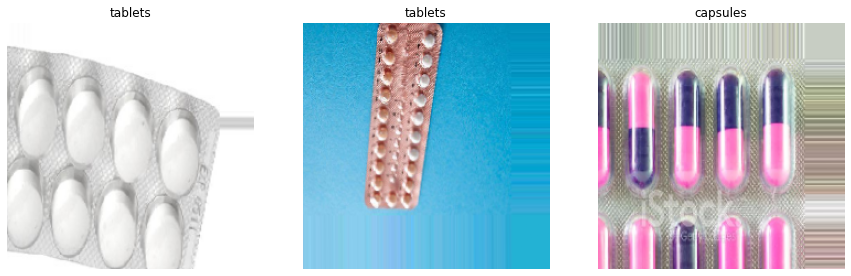

In [17]:
# Plot three random images from dataset
plot_ds_images(train_ds)

In [18]:
my_model_with_augm = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3,
                           activation='relu',
                           input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [19]:
my_model_with_augm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [20]:
my_model_with_augm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              loss=tf.keras.losses.binary_crossentropy,
                              metrics=['accuracy'])
history_my_model_with_augm = my_model_with_augm.fit(train_ds, 
                                                    epochs=20, 
                                                    steps_per_epoch=len(train_ds), 
                                                    validation_data=val_ds, 
                                                    validation_steps=len(val_ds),
                                                    callbacks=[
                                                        tf.keras.callbacks.ModelCheckpoint(checkpoints_path, 
                                                                                           save_weights_only=True,
                                                                                           save_best_only=True,
                                                                                           verbose=0),
                                                        tf.keras.callbacks.TensorBoard(tensorboard_path)])

Epoch 1/20
15/15 [==============================] - 22s 1s/step - loss: 1.4300 - accuracy: 0.5217 - val_loss: 0.7717 - val_accuracy: 0.5526
Epoch 2/20
15/15 [==============================] - 19s 1s/step - loss: 0.6941 - accuracy: 0.5261 - val_loss: 0.6629 - val_accuracy: 0.5965
Epoch 3/20
15/15 [==============================] - 19s 1s/step - loss: 0.6780 - accuracy: 0.6000 - val_loss: 0.6538 - val_accuracy: 0.6228
Epoch 4/20
15/15 [==============================] - 18s 1s/step - loss: 0.6584 - accuracy: 0.6239 - val_loss: 0.6603 - val_accuracy: 0.6140
Epoch 5/20
15/15 [==============================] - 20s 1s/step - loss: 0.6567 - accuracy: 0.6304 - val_loss: 0.6466 - val_accuracy: 0.6140
Epoch 6/20
15/15 [==============================] - 18s 1s/step - loss: 0.6501 - accuracy: 0.6304 - val_loss: 0.6519 - val_accuracy: 0.6404
Epoch 7/20
15/15 [==============================] - 19s 1s/step - loss: 0.6386 - accuracy: 0.6804 - val_loss: 0.6394 - val_accuracy: 0.6404
Epoch 8/20
15/15 [==

In [21]:
my_model_with_augm_score = my_model_with_augm.evaluate(val_ds)

4/4 [==============================] - 3s 714ms/step - loss: 0.5953 - accuracy: 0.7368


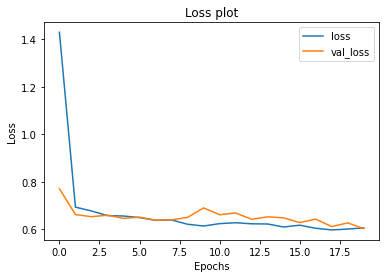

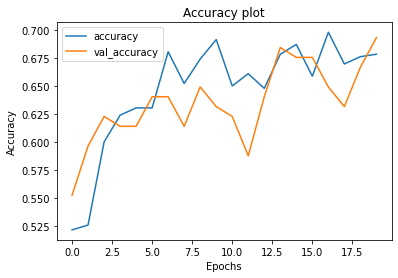

In [22]:
plot_history(history_my_model_with_augm)

Model overfitting has prevented, but perfomance of neural network is not good. Pretrained models can increase perfomance of neural network

## Using pretrained model (EfficientNetB0) without data augmentation

EfficientNet is based on the baseline network developed by the neural architecture search using the AutoML MNAS framework. The network is fine-tuned for obtaining maximum accuracy but is also penalized if the network is very computationally heavy. The architecture convolution similar to MobileNet V2 but is much larger.

In [23]:
datagen_without_augm = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2) # there's no need to rescaling


train_ds = datagen_without_augm.flow_from_directory(data_directory,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=SHAPE,
                                                    class_mode="binary",
                                                    subset='training',
                                                    seed=42)

val_ds = datagen_without_augm.flow_from_directory(data_directory,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=SHAPE,
                                                  class_mode="binary",
                                                  subset='validation',
                                                  shuffle=False,
                                                  seed=42)

Found 460 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


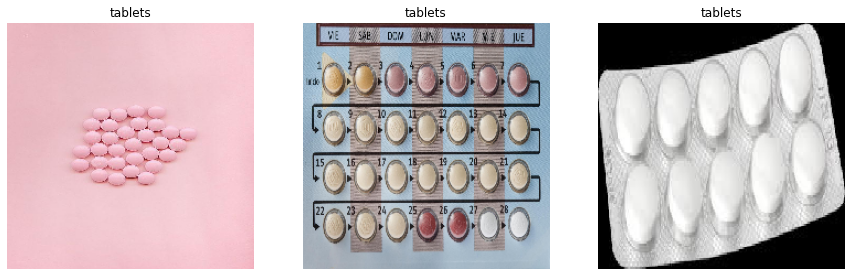

In [24]:
# Plot three random images from dataset
plot_ds_images(train_ds, rescaled=False)

In [25]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=[224, 224, 3])

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAvgPool2D()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

transf_model_without_augm = tf.keras.Model(inputs, outputs)

In [26]:
transf_model_without_augm.compile(optimizer=tf.keras.optimizers.Adam(),
                                  loss=tf.keras.losses.BinaryCrossentropy(),
                                  metrics=['accuracy'])

history_transf_model_without_augm = transf_model_without_augm.fit(train_ds, 
                                                                  epochs=10, 
                                                                  steps_per_epoch=len(train_ds), 
                                                                  validation_data=val_ds, 
                                                                  validation_steps=len(val_ds),
                                                                  callbacks=[
                                                                      tf.keras.callbacks.ModelCheckpoint(checkpoints_path, 
                                                                                                         save_weights_only=True,
                                                                                                         save_best_only=True,
                                                                                                         verbose=0),
                                                                      tf.keras.callbacks.TensorBoard(tensorboard_path)])

Epoch 1/10
15/15 [==============================] - 47s 2s/step - loss: 0.6442 - accuracy: 0.6304 - val_loss: 0.5577 - val_accuracy: 0.7544
Epoch 2/10
15/15 [==============================] - 18s 1s/step - loss: 0.4476 - accuracy: 0.8500 - val_loss: 0.4188 - val_accuracy: 0.8684
Epoch 3/10
15/15 [==============================] - 16s 1s/step - loss: 0.3457 - accuracy: 0.9000 - val_loss: 0.3345 - val_accuracy: 0.9123
Epoch 4/10
15/15 [==============================] - 16s 1s/step - loss: 0.2897 - accuracy: 0.9087 - val_loss: 0.2885 - val_accuracy: 0.9298
Epoch 5/10
15/15 [==============================] - 16s 1s/step - loss: 0.2527 - accuracy: 0.9239 - val_loss: 0.2586 - val_accuracy: 0.9474
Epoch 6/10
15/15 [==============================] - 16s 1s/step - loss: 0.2276 - accuracy: 0.9326 - val_loss: 0.2385 - val_accuracy: 0.9561
Epoch 7/10
15/15 [==============================] - 16s 1s/step - loss: 0.2067 - accuracy: 0.9435 - val_loss: 0.2220 - val_accuracy: 0.9386
Epoch 8/10
15/15 [==

In [27]:
transf_model_without_augm_score = transf_model_without_augm.evaluate(val_ds)

4/4 [==============================] - 3s 623ms/step - loss: 0.1845 - accuracy: 0.9561


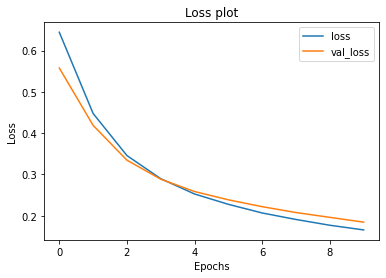

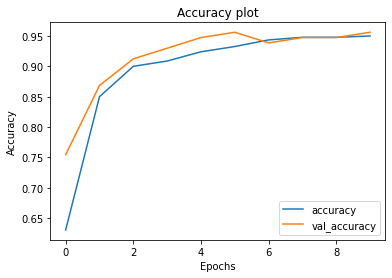

In [28]:
plot_history(history_transf_model_without_augm)

Transfer-learning model without data-augmentation has good metrics, also there are no have overfitting, but pretrained model with data augmentation can prevent overfitting in further fine-tuning.

## Using pretrained model (EfficientNetB0) with data augmentation

In [29]:
datagen_with_augm = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                                    rotation_range=0.2,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    zoom_range=0.2,
                                                                    horizontal_flip=True,
                                                                    vertical_flip=True)


train_ds = datagen_with_augm.flow_from_directory(data_directory,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=SHAPE,
                                                 class_mode="binary",
                                                 subset='training',
                                                 seed=42)

val_ds = datagen_with_augm.flow_from_directory(data_directory,
                                               batch_size=BATCH_SIZE,
                                               target_size=SHAPE,
                                               class_mode="binary",
                                               subset='validation',
                                               shuffle=False,
                                               seed=42)

Found 460 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


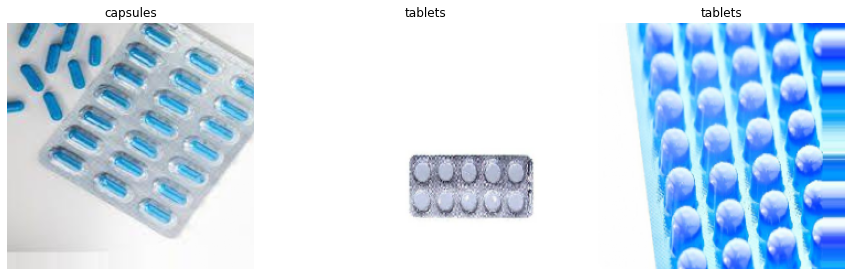

In [30]:
# Plot three random images from dataset
plot_ds_images(train_ds, rescaled=False)

In [31]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=[224, 224, 3])

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAvgPool2D()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

transf_model_with_augm = tf.keras.Model(inputs, outputs)

In [32]:
transf_model_with_augm.compile(optimizer=tf.keras.optimizers.Adam(),
                               loss=tf.keras.losses.BinaryCrossentropy(),
                               metrics=['accuracy'])

history_transf_model_with_augm = transf_model_with_augm.fit(train_ds, 
                                                            epochs=10, 
                                                            steps_per_epoch=len(train_ds), 
                                                            validation_data=val_ds, 
                                                            validation_steps=len(val_ds),
                                                            callbacks=[
                                                                      tf.keras.callbacks.ModelCheckpoint(checkpoints_path, 
                                                                                                         save_weights_only=True,
                                                                                                         save_best_only=True,
                                                                                                         verbose=0),
                                                                      tf.keras.callbacks.TensorBoard(tensorboard_path)])

Epoch 1/10
15/15 [==============================] - 47s 2s/step - loss: 0.6070 - accuracy: 0.6587 - val_loss: 0.4924 - val_accuracy: 0.8509
Epoch 2/10
15/15 [==============================] - 23s 1s/step - loss: 0.4506 - accuracy: 0.8435 - val_loss: 0.3881 - val_accuracy: 0.8772
Epoch 3/10
15/15 [==============================] - 23s 2s/step - loss: 0.3651 - accuracy: 0.8957 - val_loss: 0.3379 - val_accuracy: 0.8772
Epoch 4/10
15/15 [==============================] - 23s 1s/step - loss: 0.3139 - accuracy: 0.9130 - val_loss: 0.3208 - val_accuracy: 0.9123
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 0.2869 - accuracy: 0.9130 - val_loss: 0.2823 - val_accuracy: 0.9035
Epoch 6/10
15/15 [==============================] - 22s 1s/step - loss: 0.2680 - accuracy: 0.9239 - val_loss: 0.2549 - val_accuracy: 0.9211
Epoch 7/10
15/15 [==============================] - 22s 1s/step - loss: 0.2430 - accuracy: 0.9196 - val_loss: 0.2524 - val_accuracy: 0.9298
Epoch 8/10
15/15 [==

In [33]:
transf_model_with_augm_score = transf_model_with_augm.evaluate(val_ds)

4/4 [==============================] - 4s 761ms/step - loss: 0.2205 - accuracy: 0.9386


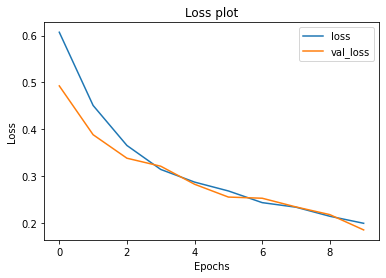

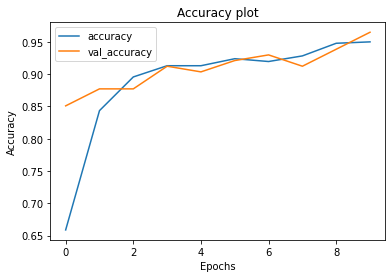

In [34]:
plot_history(history_transf_model_with_augm)

In [35]:
saved_models_path ='d:\\Python\\Проекты\\Классификация таблетки, капсулы\\saved_models\\'
transf_model_with_augm.save(saved_models_path + 'transf_model_with_augm.h5')

Transfer-learning model with data-augmentation also has good metrics and perfomance, fine-tuning of pretrained model may increase metrics of neural network

## Fine-tuning of pretrained model (EfficientNetB0) with data augmentation

In [36]:
transf_model_with_augm = tf.keras.models.load_model(saved_models_path + 'transf_model_with_augm.h5')

In [37]:
base_model.trainable = True

# Freeze all layers except for the 10 last
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model
transf_model_with_augm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower
                               metrics=["accuracy"])

In [38]:
for layer in transf_model_with_augm.layers:
    print(layer, layer.trainable)
print()
print(f'Quantity of trainable layers is {len(transf_model_without_augm.trainable_variables)}')

<keras.engine.input_layer.InputLayer object at 0x0000022EF5BD0D30> True
<keras.engine.functional.Functional object at 0x0000022EF5CF8370> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022EF5BD27A0> True
<keras.layers.core.dense.Dense object at 0x0000022EF5BD3C10> True

Quantity of trainable layers is 2


In [39]:
history_transf_model_with_augm_ft = transf_model_with_augm.fit(train_ds, 
                                                               epochs=20, 
                                                               initial_epoch=history_transf_model_with_augm.epoch[-1],
                                                               steps_per_epoch=len(train_ds), 
                                                               validation_data=val_ds, 
                                                               validation_steps=len(val_ds),
                                                               callbacks=[
                                                                 tf.keras.callbacks.ModelCheckpoint(checkpoints_path, 
                                                                                                    save_weights_only=True,
                                                                                                    save_best_only=True,
                                                                                                    verbose=0),
                                                                  tf.keras.callbacks.TensorBoard(tensorboard_path)])

Epoch 10/20
15/15 [==============================] - 47s 2s/step - loss: 0.2017 - accuracy: 0.9435 - val_loss: 0.1826 - val_accuracy: 0.9649
Epoch 11/20
15/15 [==============================] - 21s 1s/step - loss: 0.2065 - accuracy: 0.9391 - val_loss: 0.2065 - val_accuracy: 0.9298
Epoch 12/20
15/15 [==============================] - 20s 1s/step - loss: 0.1990 - accuracy: 0.9413 - val_loss: 0.2162 - val_accuracy: 0.9211
Epoch 13/20
15/15 [==============================] - 21s 1s/step - loss: 0.2008 - accuracy: 0.9435 - val_loss: 0.2010 - val_accuracy: 0.9561
Epoch 14/20
15/15 [==============================] - 21s 1s/step - loss: 0.1986 - accuracy: 0.9435 - val_loss: 0.2097 - val_accuracy: 0.9474
Epoch 15/20
15/15 [==============================] - 21s 1s/step - loss: 0.1988 - accuracy: 0.9391 - val_loss: 0.1968 - val_accuracy: 0.9474
Epoch 16/20
15/15 [==============================] - 21s 1s/step - loss: 0.1852 - accuracy: 0.9587 - val_loss: 0.1861 - val_accuracy: 0.9561
Epoch 17/20
1

In [40]:
tuned_transf_model_with_augm_score = transf_model_with_augm.evaluate(val_ds)

4/4 [==============================] - 4s 792ms/step - loss: 0.2042 - accuracy: 0.9298


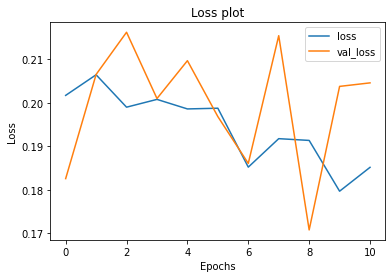

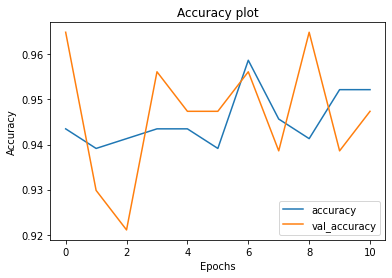

In [41]:
plot_history(history_transf_model_with_augm_ft)

In [42]:
def compare_historys(original_history, new_history, initial_epochs=10):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: tf.keras.callbacks.History from original model
      new_history: tf.keras.callbacks.History from continued model training
      initial_epochs: number of epochs in original_history
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

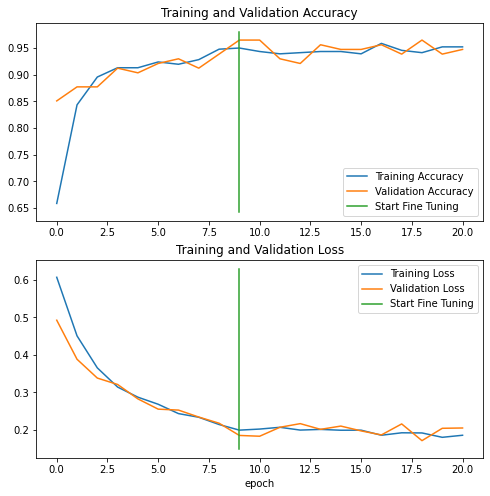

In [43]:
compare_historys(history_transf_model_with_augm, history_transf_model_with_augm_ft, initial_epochs=10)

## Evaluating model

In [44]:
# Finding best model

from varname import nameof

list_of_score_of_models = [my_model_without_augm_score, my_model_with_augm_score, 
                           transf_model_without_augm_score, transf_model_with_augm_score,
                           tuned_transf_model_with_augm_score]

df_scores = pd.DataFrame(list_of_score_of_models, columns =['Loss', 'Accuracy'], 
                         index=nameof(my_model_without_augm_score, my_model_with_augm_score, 
                                      transf_model_without_augm_score, transf_model_with_augm_score,
                                      tuned_transf_model_with_augm_score))
df_scores.sort_values('Accuracy')

,Loss,Accuracy
my_model_without_augm_score,1.492939,0.675439
my_model_with_augm_score,0.595267,0.736842
tuned_transf_model_with_augm_score,0.204193,0.929825
transf_model_with_augm_score,0.220512,0.938596
transf_model_without_augm_score,0.184459,0.956140


Transfer-learning model without augmentation based on EfficientNet B0 has the highest Accuracy, let's evaluate this model

In [61]:
model = transf_model_without_augm

In [62]:
# Probability of belonging to a class 1 (capsules: 0, tablets: 1)
pred_probs = model.predict(val_ds, verbose=1)

4/4 [==============================] - 8s 909ms/step


In [63]:
print(f"What prediction probability looks like:\n {pred_probs[:10]}")
print(f'Length of list of predicting probabilities is {len(pred_probs)}')
print(f'Shape of list of predicting probabilities is {pred_probs.shape}')

What prediction probability looks like:
 [[0.03167124]
 [0.23889035]
 [0.12166242]
 [0.18395275]
 [0.09188861]
 [0.10092089]
 [0.5456169 ]
 [0.03708572]
 [0.01872808]
 [0.13432758]]
Length of list of predicting probabilities is 114
Shape of list of predicting probabilities is (114, 1)


In [64]:
pred_classes = np.where(pred_probs >= 0.5, 1, 0)
y_labels = val_ds.labels
print(f"What prediction classes looks like: {pred_classes.squeeze()[30:60]}")
print(f"What test classes looks like: {y_labels.squeeze()[30:60]}")

What prediction classes looks like: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
What test classes looks like: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_labels, pred_classes)

0.9122807017543859

In [66]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
      """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes), # create enough axis slots for each class
           yticks=np.arange(n_classes), 
           xticklabels=labels, # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

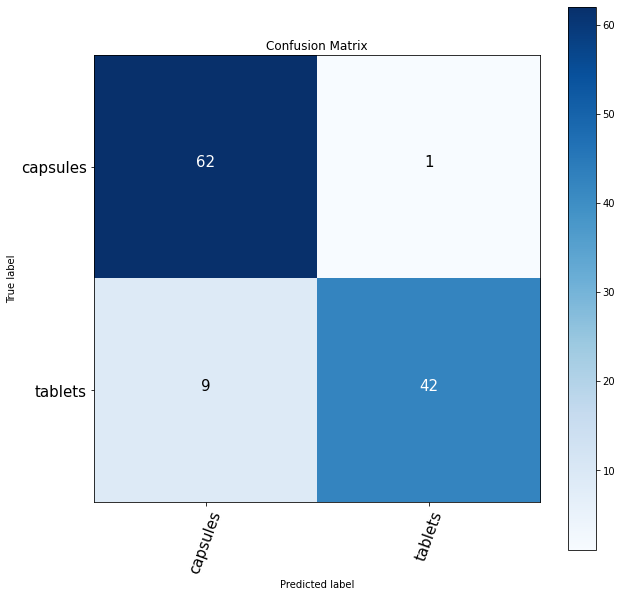

In [67]:
name_of_classes = list(train_ds.class_indices.keys())
make_confusion_matrix(y_labels, pred_classes, name_of_classes)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.98      0.93        63
           1       0.98      0.82      0.89        51

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.91      0.91       114



### Finding the most wrong predictions

In [69]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in val_ds.filenames:
    filepaths.append(val_ds.directory + '\\' + filepath)
filepaths[:10]

['d:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\1.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\10.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\100.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\102.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\103.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\104.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\105.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\106.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\107.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы/data\\capsules\\108.jpg']

In [70]:
# 2. Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes.squeeze(),
                        "pred_conf": pred_probs.squeeze(),
                        "y_true_classname": [name_of_classes[i] for i in y_labels],
                        "y_pred_classname": [name_of_classes[i] for i in pred_classes.squeeze()]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,"d:\Python\Проекты\Классификация таблетки, капс...",0,0,0.031671,capsules,capsules
1,"d:\Python\Проекты\Классификация таблетки, капс...",0,0,0.238890,capsules,capsules
2,"d:\Python\Проекты\Классификация таблетки, капс...",0,0,0.121662,capsules,capsules
3,"d:\Python\Проекты\Классификация таблетки, капс...",0,0,0.183953,capsules,capsules
4,"d:\Python\Проекты\Классификация таблетки, капс...",0,0,0.091889,capsules,capsules


In [71]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
top_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
top_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
6,"d:\Python\Проекты\Классификация таблетки, капс...",0,1,0.545617,capsules,tablets,False
106,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.485826,tablets,capsules,False
107,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.387941,tablets,capsules,False
94,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.368388,tablets,capsules,False
67,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.317352,tablets,capsules,False
85,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.297528,tablets,capsules,False
75,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.211469,tablets,capsules,False
113,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.194661,tablets,capsules,False
71,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.179309,tablets,capsules,False
78,"d:\Python\Проекты\Классификация таблетки, капс...",1,0,0.137386,tablets,capsules,False


In [77]:
# for i in top_wrong.iloc[:, 0]:
#     print(i)

In [73]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Args:
        filename (str): string filename of target image
        img_shape (int): size to resize target image to, default 224
        scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

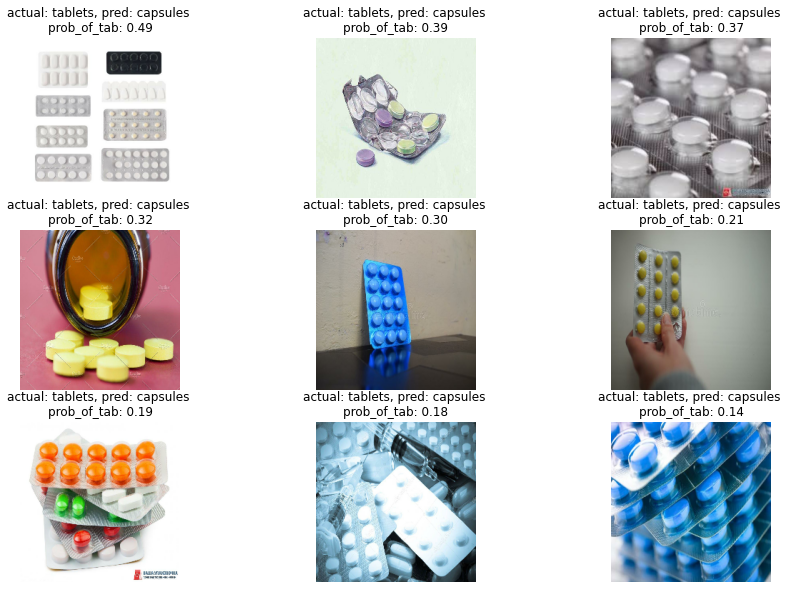

In [74]:
# 4. Visualize some of the most wrong examples
images_to_view = 9
start_index = 1 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_wrong[start_index:start_index+images_to_view].itertuples()): 
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=True)
    _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
    plt.imshow(img)
    plt.title(f"actual: {y_true}, pred: {y_pred} \nprob_of_tab: {pred_prob:.2f}")
    plt.axis(False)

I had deleted mislabeled images, added more data and repeated model training

## Predicting my own images

In [75]:
my_images_path = 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\'
my_images = [my_images_path + img_path for img_path in os.listdir(my_images_path)]
my_images

['d:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\photo_2022-12-25_18-45-38.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\photo_2022-12-25_18-45-41.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\photo_2022-12-25_18-45-44.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\photo_2022-12-25_18-45-46.jpg',
 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\my_images\\photo_2022-12-25_18-45-50.jpg']

1/1 [==============================] - 0s 86ms/step


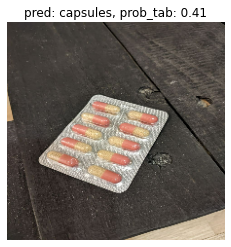

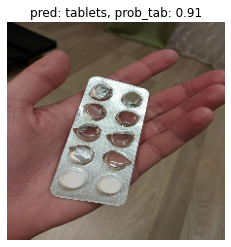

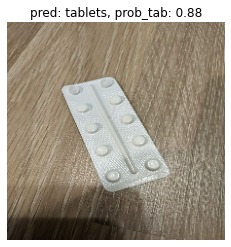

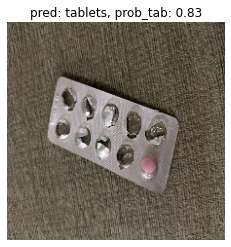

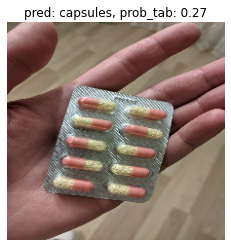

In [76]:
# Make predictions on custom food images
for img in my_images:
    img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
    pred_prob = model.predict(tf.expand_dims(img, axis=0)).squeeze() # make prediction on image with shape [None, 224, 224, 3]
    pred_class = np.where(pred_prob >= 0.5, 'tablets', 'capsules') # find the predicted class label
    # Plot the image with appropriate annotations
    plt.figure()
    plt.imshow(img/255.) # imshow() requires float inputs to be normalized
    plt.title(f"pred: {pred_class}, prob_tab: {pred_prob.max():.2f}")
    plt.axis(False)

Model works!

## Uploading model on TendorBoard

In [83]:
path_tensorboard = 'd:\\Python\\Проекты\\Классификация таблетки, капсулы\\tensorboard'

In [93]:
!tensorboard dev upload --logdir=./tensorboards \
  --name "CNN model for binary classification tablets and capsules" \
  --description "A series of different model experiments and fine-tuning" \
  --one_shot # exits the uploader when upload has finished